In [1]:
import os
import shutil
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

['mobile_image_resized', 'mobile_test.csv', 'mobile.csv']


In [2]:
import keras
from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_data = pd.read_csv('../input/mobile.csv')

Text(0.5, 1.0, 'Count Across Category Types')

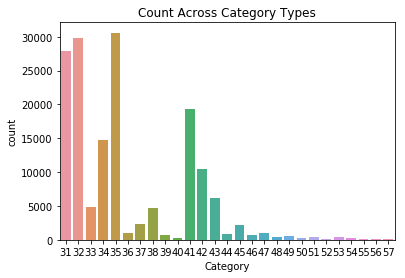

In [4]:
sns.countplot(x=train_data['Category'],data=train_data)
plt.title('Count Across Category Types')

From this we observe that the class types are imbalanced and we should adjust this before training the CNN.

# Organise images into directories

In [5]:
cwd = os.getcwd()
print ('Current directory: {}'.format(cwd))

Current directory: /kaggle/working


In [6]:
new_folder_paths = ['Train',
                    os.path.join('Train','Mobile')]
for folder_path in new_folder_paths:
    if (os.path.isdir(folder_path) is False):
        os.mkdir(folder_path)

In [7]:
folder_path_dict = {i:'Mobile' for i in range(31, 58, 1)}
for category in range(31,58,1):
        
    category_img_paths = train_data[train_data['Category']==category]['image_path'].values.tolist()
    folder_path = os.path.join('Train', folder_path_dict[category], str(category))

    if (os.path.isdir(folder_path) is False):
        os.mkdir(folder_path)

    for img_path in category_img_paths:
        img_name = img_path.split('/')[1]
        corrected_img_path = "../input/mobile_image_resized/mobile_image_resized/train/"
        
        # Copy images into their appropriate category folders
        shutil.copy(os.path.join('../input/mobile_image_resized/mobile_image_resized/train/', img_name), os.path.join(folder_path, img_name))


## Split the Mobile Train set into train & test set

In [8]:
# Directories for our training & test splits
base_dir = os.path.join(os.getcwd(), 'Train', 'Mobile')
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training categories
n_labels = 58
for category_id in range(31,n_labels,1):
    train_category_dir = os.path.join(train_dir, str(category_id))
    if (os.path.isdir(train_category_dir) is False):
        os.mkdir(train_category_dir)

# Directory with our test categories
for category_id in range(31,n_labels,1):
    test_category_dir = os.path.join(test_dir, str(category_id))
    if (os.path.isdir(test_category_dir) is False):
        os.mkdir(test_category_dir)

In [9]:
# Directory for individual subcategory
# Organise data into proper structure
test_indi_dir = os.path.join(base_dir, 'test_indi')
os.mkdir(test_indi_dir)

# Create directories within test_indi
for category_id in range(31,n_labels,1):
    test_indi_category_dir = os.path.join(test_indi_dir, str(category_id))
    if (os.path.isdir(test_indi_category_dir) is False):
        os.mkdir(test_indi_category_dir)
    for category_id in range(31,n_labels,1):
        test_indi_category_dir_int = os.path.join(test_indi_category_dir, str(category_id))
        if (os.path.isdir(test_indi_category_dir_int) is False):
            os.mkdir(test_indi_category_dir_int)

In [ ]:
os.listdir('/kaggle/working/Train/Mobile/test_indi/31/31')

In [10]:
# Move image files into the train directories
train_ratio = 0.7; test_ratio = 0.3

for category in range(31,58,1):
    category_size = len(os.listdir(os.path.join(base_dir, str(category))))
    train_size = int(train_ratio * category_size)
    test_size = int(test_ratio * category_size)
    
    # Move data from category_dir to create test set for category
    category_dir = os.path.join(base_dir, str(category))
    test_category_dir = os.path.join(test_dir, str(category))
    fnames = os.listdir(category_dir)[train_size:train_size+test_size]
    for fname in fnames:
        src = os.path.join(category_dir, fname)
        dst = os.path.join(test_category_dir, fname)
        shutil.move(src, dst)
        
    # Move data from category_dir to create train set for category
    category_dir = os.path.join(base_dir, str(category))
    train_category_dir = os.path.join(train_dir, str(category))
    fnames = os.listdir(category_dir)[0:train_size]
    for fname in fnames:
        src = os.path.join(category_dir, fname)
        dst = os.path.join(train_category_dir, fname)
        shutil.move(src, dst)

In [11]:
# Copy images from test set for each category into test_indi categories
for category in range(31,58,1):
    test_category_dir = os.path.join(test_dir, str(category))
    test_indi_category_dir = os.path.join(test_indi_dir, str(category),str(category))
    fnames = os.listdir(test_category_dir)
    for fname in fnames:
        src = os.path.join(test_category_dir, fname)
        dst = os.path.join(test_indi_category_dir, fname)
        shutil.copy(src, dst)

# CNN for Train Set

In [12]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Prep images for CNN
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Modify this to pass this category by category
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 112217 images belonging to 27 classes.
Found 48089 images belonging to 27 classes.


In [ ]:
os.path.join(test_dir, str(31))

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(27, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 27s 273ms/step - loss: 2.3874 - acc: 0.1772
Epoch 2/20
100/100 [==============================] - 26s 256ms/step - loss: 2.3204 - acc: 0.2006
Epoch 3/20
  2/100 [..............................] - ETA: 21s - loss: 2.2804 - acc: 0.1875

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113359). Check your callbacks.
  % delta_t_median)


 37/100 [==========>...................] - ETA: 15s - loss: 2.2390 - acc: 0.2061

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102778). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 25s 248ms/step - loss: 2.3077 - acc: 0.2006
Epoch 4/20
100/100 [==============================] - 25s 251ms/step - loss: 2.2910 - acc: 0.2119
Epoch 5/20
100/100 [==============================] - 25s 252ms/step - loss: 2.2719 - acc: 0.2206
Epoch 6/20
  2/100 [..............................] - ETA: 18s - loss: 2.1075 - acc: 0.2500

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104314). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 25s 247ms/step - loss: 2.2712 - acc: 0.2269
Epoch 7/20
100/100 [==============================] - 25s 248ms/step - loss: 2.2607 - acc: 0.2384
Epoch 8/20
100/100 [==============================] - 26s 257ms/step - loss: 2.2300 - acc: 0.2422
Epoch 9/20
  2/100 [..............................] - ETA: 21s - loss: 2.0138 - acc: 0.2969

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116553). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 25s 247ms/step - loss: 2.2055 - acc: 0.2578
Epoch 10/20
 78/100 [======================>.......] - ETA: 5s - loss: 2.2026 - acc: 0.2640

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100969). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 26s 258ms/step - loss: 2.2138 - acc: 0.2609
Epoch 11/20
100/100 [==============================] - 26s 256ms/step - loss: 2.2117 - acc: 0.2716
Epoch 12/20
100/100 [==============================] - 24s 244ms/step - loss: 2.1738 - acc: 0.2694
Epoch 13/20
100/100 [==============================] - 25s 246ms/step - loss: 2.1687 - acc: 0.2838
Epoch 14/20
100/100 [==============================] - 26s 256ms/step - loss: 2.1203 - acc: 0.2866
Epoch 15/20
100/100 [==============================] - 24s 245ms/step - loss: 2.1763 - acc: 0.2853
Epoch 16/20
 67/100 [===================>..........] - ETA: 8s - loss: 2.1167 - acc: 0.3046

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100969). Check your callbacks.
  % delta_t_median)
/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102336). Check your callbacks.
  % delta_t_median)
/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102336). Check your callbacks.
  % delta_t_median)


 69/100 [===================>..........] - ETA: 7s - loss: 2.1198 - acc: 0.3034

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103826). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 25s 245ms/step - loss: 2.1443 - acc: 0.2972
Epoch 17/20
 24/100 [======>.......................] - ETA: 18s - loss: 2.1546 - acc: 0.3060

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104031). Check your callbacks.
  % delta_t_median)
/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104031). Check your callbacks.
  % delta_t_median)


 26/100 [======>.......................] - ETA: 17s - loss: 2.1368 - acc: 0.3089

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104031). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 26s 256ms/step - loss: 2.1347 - acc: 0.2928
Epoch 18/20
100/100 [==============================] - 24s 243ms/step - loss: 2.0958 - acc: 0.3131
Epoch 19/20
  4/100 [>.............................] - ETA: 21s - loss: 2.0831 - acc: 0.3047

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104094). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 24s 245ms/step - loss: 2.1011 - acc: 0.3109
Epoch 20/20
100/100 [==============================] - 25s 251ms/step - loss: 2.0890 - acc: 0.3119


In [16]:
model.save('cnn_baseline_beauty.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test model on test set

In [17]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50, verbose=1)
print('test acc:', test_acc)

50/50 [==============================] - 7s 137ms/step
test acc: 0.3075


## Obtain individual sub-category accuracy

In [18]:
test_gen_indi = []
for i in range(31,58,1): # Modify this part if using other datasets
    test_gen_indi.append(test_datagen.flow_from_directory(
        os.path.join(test_indi_dir, str(i)),
        target_size=(150,150),
        batch_size=32,
        class_mode='categorical'))

Found 8350 images belonging to 27 classes.
Found 8926 images belonging to 27 classes.
Found 1446 images belonging to 27 classes.
Found 4415 images belonging to 27 classes.
Found 9177 images belonging to 27 classes.
Found 308 images belonging to 27 classes.
Found 681 images belonging to 27 classes.
Found 1410 images belonging to 27 classes.
Found 209 images belonging to 27 classes.
Found 98 images belonging to 27 classes.
Found 5793 images belonging to 27 classes.
Found 3150 images belonging to 27 classes.
Found 1844 images belonging to 27 classes.
Found 276 images belonging to 27 classes.
Found 658 images belonging to 27 classes.
Found 205 images belonging to 27 classes.
Found 283 images belonging to 27 classes.
Found 124 images belonging to 27 classes.
Found 171 images belonging to 27 classes.
Found 84 images belonging to 27 classes.
Found 121 images belonging to 27 classes.
Found 35 images belonging to 27 classes.
Found 125 images belonging to 27 classes.
Found 90 images belonging to

In [19]:
test_acc_subcat = []
for i, j in enumerate(range(31,58,1)):
    test_loss, test_acc = model.evaluate_generator(test_gen_indi[i], steps=50)
    print('test acc {}:'.format(j), test_acc)
    test_acc_subcat.append(test_acc)

test acc 31: 0.7025
test acc 32: 0.33125
test acc 33: 0.0
test acc 34: 0.2
test acc 35: 0.1775
test acc 36: 0.0
test acc 37: 0.0
test acc 38: 0.07707006369426751
test acc 39: 0.0
test acc 40: 0.0
test acc 41: 0.383125
test acc 42: 0.44125
test acc 43: 0.0
test acc 44: 0.0
test acc 45: 0.0
test acc 46: 0.17177914142425807
test acc 47: 0.0
test acc 48: 0.0
test acc 49: 0.0
test acc 50: 0.0
test acc 51: 0.0
test acc 52: 0.0
test acc 53: 0.0
test acc 54: 0.0
test acc 55: 0.0
test acc 56: 0.0
test acc 57: 0.0


In [20]:
test_acc = pd.DataFrame(test_acc_subcat)
subcat = range(31,58)
test_acc['sub_cat'] = subcat 
test_acc.columns = ['Accuracy', 'Sub_cat']

Text(0.5, 1.0, 'Accuracy Across Category Types')

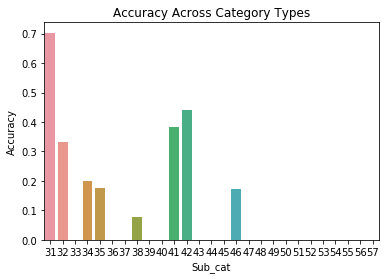

In [21]:
sns.barplot(x=test_acc['Sub_cat'], y=test_acc['Accuracy'],data=test_acc)
plt.title('Accuracy Across Category Types')